<a href="https://colab.research.google.com/github/SergeyBryukhanov/SergeyBryukhanov/blob/main/educational_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучение модели по прогнозированию результатов одобрения кредита на основе индивидуальных данных заявителя.
Ссылки на дата-сет:
 https://www.kaggle.com/datasets/itshappy/ps4e9-original-data-loan-approval-prediction?resource=download

 https://drive.google.com/file/d/18TdYgTVgQYcfbpcxUhLPxCx30rUzJWZz/view?usp=sharing

In [2]:
! gdown 18TdYgTVgQYcfbpcxUhLPxCx30rUzJWZz
! unzip -qo "loans.zip" -d ./loans
FILE_PATH = './loans'

Downloading...
From: https://drive.google.com/uc?id=18TdYgTVgQYcfbpcxUhLPxCx30rUzJWZz
To: /content/loans.zip
100% 377k/377k [00:00<00:00, 57.8MB/s]


In [1]:
!pip install -q scikit-learn

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance, plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_main = pd.read_csv(f'{FILE_PATH}/credit_risk_dataset.csv')

In [5]:
df_main.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
from sklearn.preprocessing import LabelEncoder

# Преобразуем категориальные данные в числовые
encoder = LabelEncoder()
df = df_main
df['cb_person_default_on_file']  = encoder.fit_transform(df['cb_person_default_on_file'])
df['person_home_ownership']  = encoder.fit_transform(df['person_home_ownership'])
df['loan_intent']  = encoder.fit_transform(df['loan_intent'])
df['loan_grade']  = encoder.fit_transform(df['loan_grade'])

In [7]:
# Создание модели на данных без обработки

X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_a = accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.9338652754334816


In [8]:
# Точность составила 93,4%.
# Теперь построим пару графиков и посмотрим есть аномалии в дата-сете, обработав их точность модели может быть увеличена

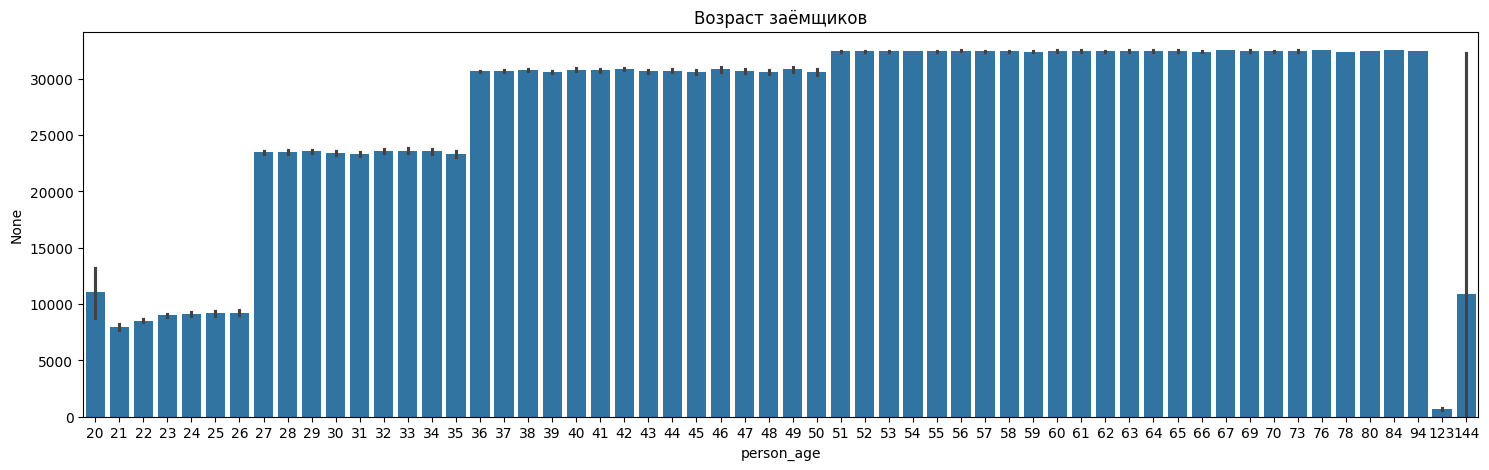

In [9]:
plt.figure(figsize=(18, 5))
sns.barplot(y=df.index, x='person_age', data=df)
plt.title('Возраст заёмщиков')
plt.show()

In [10]:
# Два последних столбца явно выглядят как аномалия, удалим их

df = df.drop(df[df.person_age > 94].index)

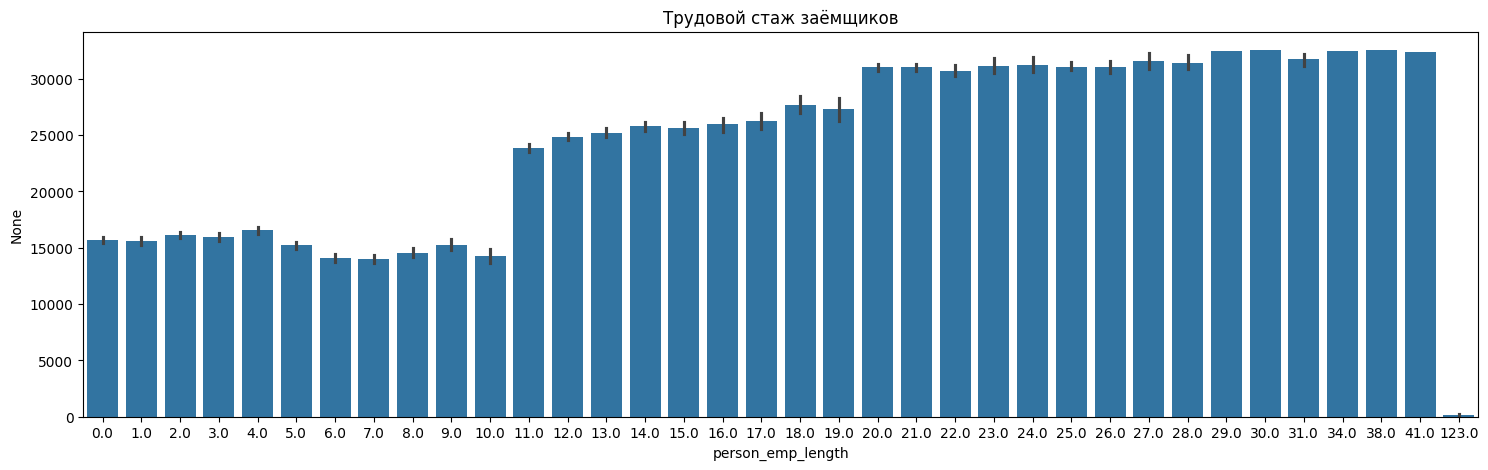

In [11]:
plt.figure(figsize=(18, 5))
sns.barplot(y=df.index, x='person_emp_length', data=df)
plt.title('Трудовой стаж заёмщиков')
plt.show()

In [12]:
# Последний столбец абсурден, отбросим его

df = df.drop(df[df.person_emp_length > 41].index)

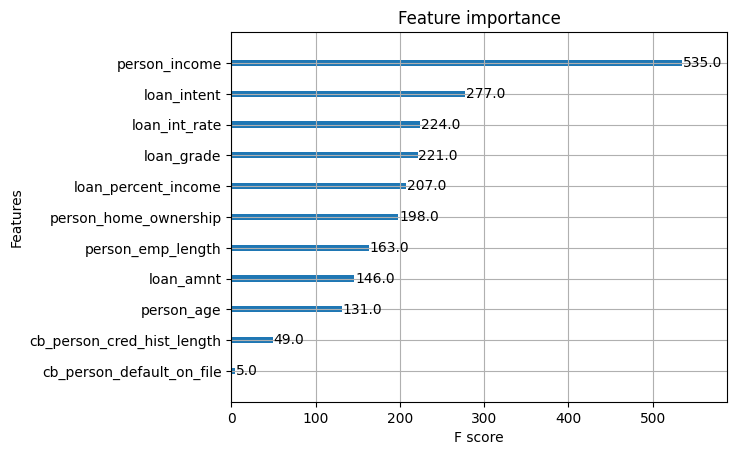

In [13]:
# Построим график важности признаков, возможно некоторые признаки не представляют интереса для модели

plot_importance(model)
plt.show()

In [14]:
# Построим модель без учёта двух последних по важности признаков

X = df.drop(['loan_status', 'cb_person_default_on_file', 'cb_person_cred_hist_length'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9366078280890253


In [15]:
print(f"Увеличение точности: {accuracy - accuracy_a}")

Увеличение точности: 0.002742552655543684


In [16]:
# В результате удалось увеличить точость на 0,27% просто за счет удаления очевидных аномалий в дата-сете

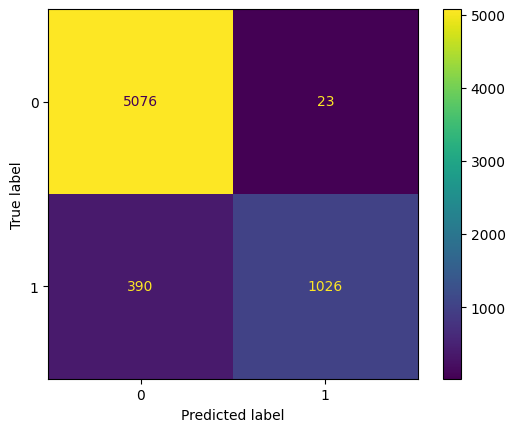

In [17]:
# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Создание отчета о классификации
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5099
           1       0.98      0.72      0.83      1416

    accuracy                           0.94      6515
   macro avg       0.95      0.86      0.90      6515
weighted avg       0.94      0.94      0.93      6515

